# Laplacian Eigenmaps

Based on 2019 notebook written by Dr James Clough

Use of manifold learning is motivated, for many biomedical applications, by the fact that our datasets have very high dimensionality and this makes analysis challenging. At the same, time data will usually be generated by natural process with fewer degress of freedom than the dimensionality of the data would suggest. Manifold learning techniques provide a framework for determining these underlying degrees of freedom in the data.

To understand this better, let's look at a simple example in which linear methods like PCA fail to uncover the data's natural non-linear structure.

Starting by importing all the modules we need

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting with matplotlib
import numpy as np

from sklearn.decomposition import PCA   # sklearn has a nice PCA implementation
from scipy.linalg import eigh           # eigendecomposition

# display plots in the notebook
%matplotlib inline    


## Exercise 1 - applying principal component analysis to the swiss roll problem

First, we need to generate the swiss-roll dataset. We start with a set of  𝑁  points scattered in a 2D unit square, and will then map those points to lie on a spiral shape in 3D. Here, parameter num_rotations sets the number of full rotations of the swiss-roll spiral. Run the code below - if you like, you can try changing the variables here to generate different datasets.

In [2]:
def create_spiral(M, num_rotations):
    """ Take 2D manifold M and output 3D spiral made from curling up M in 3D space """
    N = M.shape[0]
    r = np.exp(M[:,1] * num_rotations) * 0.5
    theta = M[:,1] * (2 * np.pi) * num_rotations
    X = np.zeros((N, 3))
    X[:,0] = M[:,0] * 6
    X[:,1] = r * np.cos(theta)
    X[:,2] = r * np.sin(theta)
    return X

N = 2000                       # number of datapoints
num_rotations = 1.2
X_m = np.random.random((N, 2)) # random points scattered in [0,1]^2

X = create_spiral(X_m, num_rotations)

Now we have generated the swiss-roll dataset, we can plot it. Think of the original 2D data as the 'underlying degrees of freedom. Think of the 3D data as the high-dimensional data we have measured.

<Figure size 432x288 with 0 Axes>

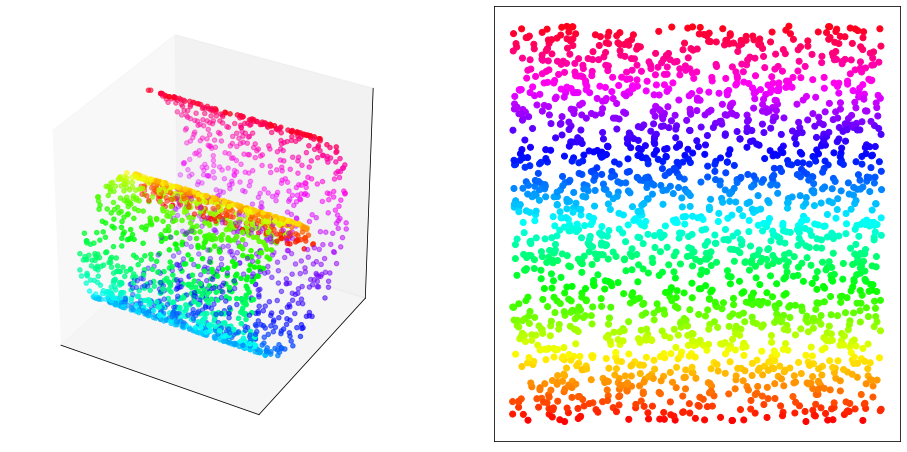

In [3]:
""" Plot the manifold curled up into a 3D swiss-roll"""
plt.set_cmap("hsv")

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121, projection='3d')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
_ = ax.scatter(X[:,0], X[:,1], X[:,2], c=X_m[:,1], marker='o')

ax = fig.add_subplot(122)
ax.set_xticks([])
ax.set_yticks([])
_ = ax.scatter(X_m[:,0], X_m[:,1], c=X_m[:,1], marker='o')
# Optional - try changing view to align with y-Z axis
#ax.view_init(azim=0,elev=0) 



PCA projects the data onto the hyperplane minimising the approximation error, or, equivalently, maxmising the variance along the hyperplane.

**What do you expect to happen if we use PCA to reduce the dimensionality of this swiss-roll dataset from 3 dimensions to 2?**

**To do** fit sklearns' PCA model to the spiral dataset we just generated

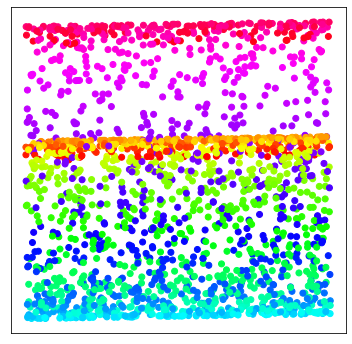

In [4]:
""" Try using PCA on this dataset and see if it can recover the underlying 2D structure """

# In scikit-learn, we first create a PCA object...
# n_components refers to the number of principal components we're extracting
# ie. the dimensionality of the space we are trying to find
pca = PCA(n_components=2)

# Then apply in to our dataset
X_pca = pca.fit_transform(X)

# plotting the result of the PCA projection
plt.figure(figsize=(6,6))
plt.xticks([])
plt.yticks([])
_ = plt.scatter(X_pca[:,0], X_pca[:,1], c=X_m[:,1], marker='o')

**What is going wrong here?**

The exact shape of the data you see will vary depending on the random points you started with, but it is unlikely that you will recover something very much like our original 2D dataset; rather the spiral structure will be projected down onto a plane that aligns with the main axis of variance through the data.

We have failed to uncover the 2D manifold structure because PCA can only project the data on to a hyperplane and it can't unfurl curved manifolds.

Another way of thinking about this problem is to notice that we want to measure the distances between points as the distance along the manifold (ie. along the swiss-roll) but if the manifold is curved, that is not the same as the distance between the points in the high-dimensional space (ie. the distance in 3D space not confined to the surface of the swiss-roll).

## Learning embeddings from the eigenvectors of graph Laplacian


To try and solve this problem we need non-linear manifold learning.

There are lots of non-linear manifold learning algorithms, but we'll be using one called Laplacian Eigenmaps, which is a simple but effective and commonly used algorithm.

**Laplacian Eigenmaps for Dimensionality Reduction and Data Representation**, *Belkin and Niyogi, Neural Computation, 2003*

The key idea is this that even if the manifold that the data lies on is curved, we can assume that it is locally flat. Specifically, we will trust Euclidean distances in the local neighbourhood of each point, but will ignore (remove) distances from all but our k-nearest neighbours in what follows.

### Estimating a Nearest Neighbour Graph

The first step in many manifold learning methods is to find the k-nearest neighbours of each point. 

This just means that we choose a number, $k$, and for each point in our data, find the $k$ points which are nearest to it. The result can be described mathematically as a ***graph***. 

Here, a graph is not the thing with an x-axis and a y-axis and a line - rather it is a mathematical object (studied in Graph Theory - https://en.wikipedia.org/wiki/Graph_theory) that consists of some points, or **vertices**, and some relations between them, or **edges**.

In this case, the vertices in the graph are our datapoints, and there will be an edge between two points if one of them is in the k-nearest neighours of the other.

<img src="imgs/scatter.png">

<img src="imgs/scatter_knn.png">

Let's write a function that finds the k-nearest neighbours of each point in our dataset.

### Exercise 2 - Create a _symmetric_ k-Nearest neighbour graph

Write a function, ***my_knn*** that takes in an array of size NxD of the datapoints, and an integer k, and returns an NxN array where the [i,j] element of the array is a 1 if j is a k-nearest-neighbour of i (excluding i itself), and 0 otherwise.

Don't worry too much about doing this in a clever or fast way, just make sure your function gives you the correct answer.

**To do** complete this kNN function to implement the steps of k-nearest neighbour implementation (up to but not including making it symmetric)

**Steps**
1. Estimate the squared distances between point i and all neighbours
2. Find the indices of the nearest neighbours (2 lines) *Hint - numpy has a function called **argsort** that you might find useful*
3. Input the nearest neighbours for the point of $i$ by filling in row $i$ of the matrix $\mathbf{A}$

<details>
  <summary>Click me for hints </summary>

1. For each loop you need to estimate the square distance between a point ```X[i]``` and all other points.
    - Python can do this using broadcasting to subtract vector ``X[i]``` from X
    - don't forget pythagoras c^2 = a^2 + b^2 - you need a sum of square over the features (columns) 
    - will return a scalar distance between each point (there are N of them)

2 To obtain the indices of the closest neighbour you need two steps 
     - sort by increasing distance
     - select the nearest k 
     - don't forget to exlude distances between piunts 

3 A starts as a matrix of all zeros - it needs ones for the neighbours of i
    
<details>

In [5]:
def my_knn(X, k):
    """ Finds k-nearest neighbours in X """
    N, D = X.shape
    A = np.zeros((N, N))
    for i in range(N):
        # 2.1 estimate the squared distances between point i and all neighbours
        # Distances can be estimated with broadcasting - X-X[i]
        # Need square distance – so use power operator **2
        # Want sum of squares over features (columns)  - achieved using np.sum over column axis (1) 
        i_sq_distances =np.sum((X - X[i])**2, axis=1)
        # 2.2 find the nearest points
        # First get indices of nearest points using np.argsort(i_sq_distances)
        nearest_points = np.argsort(i_sq_distances)
        # Return the k nearest (ignoring the first one as that will be the distance between point and itself)
        # [1:k+1] is because the nearest point to i is i itself - but we don't want it
        k_nearest      = nearest_points[1:k+1]
        for j in k_nearest:
            # 2.3 A is initialised using np.zeros((N,N))so we just need to add ones for the ids of nearest neighbours
            A[i,j] = 1
    return A

A = my_knn(X, 20)

The result of your k-nearest-neighbours function should be an NxN matrix, which has a 1 for nearest-neighbours and a 0 otherwise.

Check that the function is working properly by running the below cell. This will plot a point (red) with its neighbours coloured in dark blue. 

**Are all these values clustered similarly to our results (demoed below)**


<img src="imgs/neighbours.png">

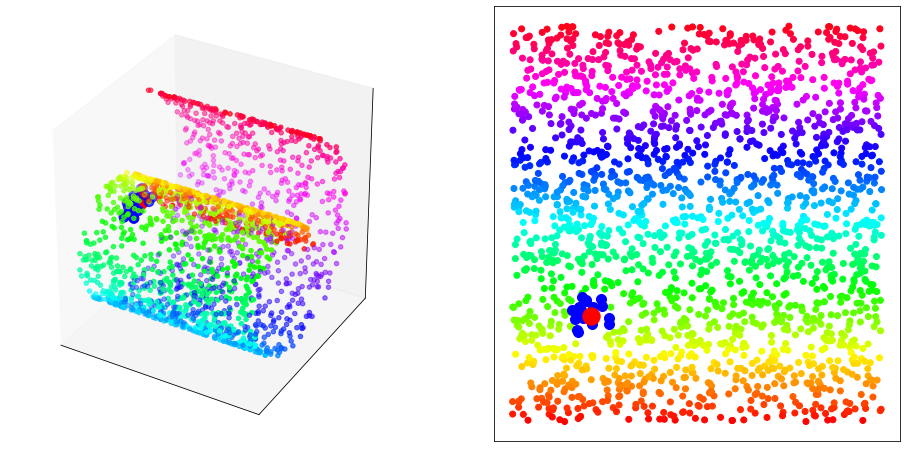

In [6]:
i = 2
knn_i = A[i].nonzero()

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(121, projection='3d')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
_ = ax.scatter(X[:,0], X[:,1], X[:,2], c=X_m[:,1], marker='o')
_ = ax.scatter(X[i,0], X[i,1], X[i,2], c='r', marker='o', s=300) # plot point i
_ = ax.scatter(X[knn_i,0], X[knn_i,1], X[knn_i,2], c='b', marker='o', s=100) # plot i's nearest neighbours


ax = fig.add_subplot(122)
ax.set_xticks([])
ax.set_yticks([])
_ = ax.scatter(X_m[:,0], X_m[:,1], c=X_m[:,1], marker='o')
_ = ax.scatter(X_m[knn_i,0], X_m[knn_i,1], c='b', marker='o', s=100) # plot i's nearest neighbours
_ = ax.scatter(X_m[i,0], X_m[i,1], c='r', marker='o', s=300) # plot point i

To use in the Laplacian Eigenmaps method, this matrix needs to be symmetric.

Does your knn algorithm always return a symmetric matrix? If not, we can symmetrise it. 

**To do** Run the cell below to return a symmetric your k-nearest neighbour _adjacency_ matrix $\mathbf{A}$

In [7]:
def symmetrise(X):
    """ Symmetrises the matrix X.
    
    Notes
    -----
    np.maximum returns the element-wise maximum of its arguments."""
    return np.maximum(X, X.T)
A = symmetrise(A)

### Derivation of the Laplacian Eigenmaps solution 

So, our aim is to find low-dimensional coordinates which maintain the near-neighbour relationships from the original data.

We will say that we are trying to minimise the following cost function:

$C = \sum_{i,j} (y_i - y_j)^2 \mathbf{A}_{ij}$

Where $\mathbf{A}_{ij}$ is our nearest-neighbour matrix which tells us whether two points are close together in the original dataset, and the $y_i$ and $y_j$ represent the low-dimensional coordinates we're trying to find.

$\mathbf{A}$ is fixed, and determined by our input data.
$\mathbf{y}$ is the solution we are trying to find.

You can hopefully see that this <span style="color:red"> </span> cost function is minimised if we place points which are close together in the original data (ie. $\mathbf{A}_{ij}$ is high), close together in the new low-dimensional representation (so that $(x_i - x_j)^2$ is low). However, there are some trivial solutions we want to avoid. **Can you tell what these are?**

**Answer** We seek a solution to $C = \sum_{i,j} (y_i - y_j)^2 \mathbf{A}_{ij}$, which avoids the trivial solution where all points get mapped onto a single location (i.e. either all $y_i=0$ or $y_i=y_j$ for all connected points).

We can find a solution by multiplying out our cost function and substituting for $\mathbf{D}_{ii} = \sum_j \mathbf{A}_{ij}$.

$C = \sum_{i,j} (y_i - y_j)^2 \mathbf{A}_{ij}$

$C = \sum_{i,j} (y_i^2 + y_j^2 - 2 y_i y_j) \mathbf{A}_{ij}$

$C = \sum_i y_i^2 \mathbf{D_{ii}} +  \sum_j y_j^2 \mathbf{D_{jj}} - 2 \sum_{i,j} y_i y_j \mathbf{A}_{ij}$

$C = \mathbf{y^TDy} - \mathbf{y^TAy}$

$C = \mathbf{y^TLy}$

where $\mathbf{L=D-A}$ is the graph laplacian. Thus we want to find the $\mathbf{y}$ for which $\mathbf{y^TLy}$ are minimised, subject to the contraints that $y_i\neq0$ or $y_i \neq y_j$. This is given by the eigenvectors of the graph Laplacian.

#### Optional explaination

For the first constraint $y_i\neq0$, this can be solved by writing the constrained minmisation as the unconstrained problem:

$$\min_{𝑓\neq 0 \in \mathbb{R}^n} \frac{\mathbf{y^TLy}}{\mathbf{y^Ty}}$$

Which is known as a Rayleigh quotient for which the solution is the eigenvector corresponding to the smallest eigenvalue of $L$. However, the smallest eigenvalue of the graph laplacian is zero and it corresponds to the constant eigenvector $\mathbb{1}$. This also is undesirable as it corresponds to the solution $y_i=y_j$; 

## _Essential_ knowledge

Under the following assumptions:
1. you have a fully connected graph (and thus only one zero eigenvalue) 
2. you want a 2D embedding

**The solution to Laplacian Eigenmaps is given by the eigenvectors corresponding to the second and third smallest eigenvalues of the graph Laplacian** 

**In the generic case**, for an N-D embedding, **you must take N eigenvector corresponding to the $N$ eigenvalues after the last 0 eigenvalue**

Importantly, note **unlike** PCA there is no need to project the data onto the eigenvectors - **the eigenvectors ARE the embeddding**

## Exercise 3 - implement the Laplacian Eigenmaps embedding of the swiss roll data set

Write a function that takes in an adjacency matrix and implements Laplacian eigenmap method described above.

*Hints**
- scipy has a function called scipy.linalg.eigh which can help you fund the eigenvectors of a matrix efficiently
- this is imported at the start of the notebook as '''eigh'''
- you must make sure to ignore eigenvectors corresponding to 0 eigenvalues; this can be achieved through using argument 'subset_by_index' which controls the range of eigenvalue/eigenvector pairs returned (i.e. ignoring the zeroth and selecting from the first to the dth index)

**To do** 
- complete the function below to extract the correct eigenvectors from the Laplacian and plot the embedding. 
- Can your method recover the original manifold structure? 
- Try changing the the number of nearest neighbours $k$. 
- What happens when $k$ is set very high, or very low?

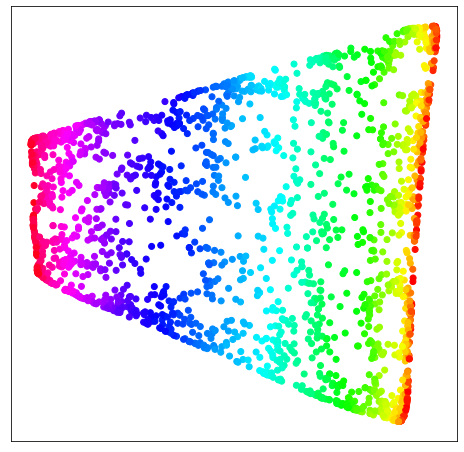

In [8]:
def my_laplacian_eigenmap(X, k=20, d=2):
    # 3.1 a use function my_knn to return A
    A = my_knn(X, k)
    # 3.1 b use function symmetrise to make A symmetric
    A = symmetrise(A)
    # 3.2 create diagonal matrix D from A
    # the degree of each number is the sum the Adjacency for that row/column
    #(remember symmetric so these are the same)
    # to make a vector into a diagonal matrix using np.dig
    D = np.diag(np.sum(A, axis=0))
    # 3.3 create L
    L = D - A
    # 3.4 return eigenvectors of L using np.eigh
    # eigvals=(1,d) returns the d smallest (above 0 - in this case corresponding to indices 1 and 2)
    v, X = eigh(L, eigvals=(1,d))
    return X

Z = my_laplacian_eigenmap(X)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
_ = ax.scatter(Z[:,0], Z[:,1], c=X_m[:,1], marker='o')

## (Optional) The normalised graph Laplacian

Strictly, Laplacian Eigenmaps do not use $\mathbf{L=D-A}$, but instead seek eigenvectors of the normalised graph Laplacian - the solutions to the generalised eigenvector problem $\mathbf{Ly}=\lambda\mathbf{Dy}$

If the graph is very regular and most vertices have approximately the same degree, then the normalised Laplacian and unnormalised Laplacian will generate very similar results. However, if the degrees in the graph are very broadly distributed it is more stable to use a normalised Laplacian $\mathbf{L=D^{-1/2}(D-A)D^{-1/2}}$. By default this is the approach taking by Scikit Learn.

## Exercise 4 - Implementing Laplacian Eigenmaps with Scikit Learn

Another name for Laplacian Eigenmaps is [spectral embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html#sklearn.manifold.SpectralEmbedding) . This is because the Graph Laplacian can be seen as a discrete version of the Laplace operator which describes diffusion on a surface. And, by looking at the eigenvectors (or spectra) of this matrix (equivalent to the eigenmodes of the Laplace operator) we can see the most significant modes of variation in the graph representing our original data.

Laplacian Eigenmaps may therefore be implemented in scikit learn using the ```SpectralEmbedding``` function from the ```manifold``` module. 

**To do** Using what you know about the consistency of the scikit-learn API implement laplacian eigenmaps using sklearn. You can use the link above for guidance

**hint** you will need to set the ```n_components``` and ```n_neighbour``` arguments

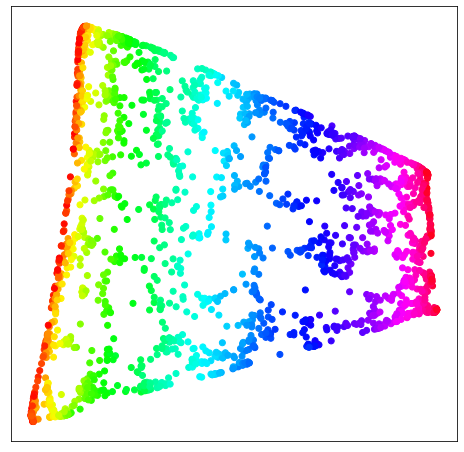

In [9]:
from sklearn.manifold import SpectralEmbedding

model=SpectralEmbedding(n_components=2,n_neighbors=10)

Z_2 = model.fit_transform(X)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xticks([])
ax.set_yticks([])
_ = ax.scatter(Z_2[:,0], Z_2[:,1], c=X_m[:,1], marker='o')